In [9]:
# import os
# import sys
# import numpy as np
# from pathlib import Path
# import matplotlib.pyplot as plt

# if 'SUMO_HOME' in os.environ:
#     tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
#     sys.path.append(tools)
# else:
#     sys.exit("SUMO_HOME not found")

# import traci

# class RampMeteringEnv:
#     def __init__(self):
#         self.cfg_path = str(Path("D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"))
#         self.sumoCmd = ["sumo", "-c", self.cfg_path, "--no-step-log", "--no-warnings"]
        
#         # State/Action spaces
#         self.n_states = 100  # 10x10 density levels
#         self.n_actions = 4   # Green time durations
#         self.q_table = np.zeros((self.n_states, self.n_actions))
        
#         # Network elements
#         self.mainline = "2to3"
#         self.ramp = "intramp"
#         self.tl_id = "node6"

#     def start_simulation(self):
#         try:
#             traci.start(self.sumoCmd)
#             return True
#         except Exception as e:
#             print(f"Error: {e}")
#             return False

#     def get_state(self):
#         mainline_density = min(9, traci.edge.getLastStepVehicleNumber(self.mainline))
#         ramp_density = min(9, traci.edge.getLastStepVehicleNumber(self.ramp))
#         return mainline_density * 10 + ramp_density

#     def take_action(self, action):
#         green_times = [5, 10, 15, 20]
#         try:
#             traci.trafficlight.setPhaseDuration(self.tl_id, green_times[action])
#             for _ in range(green_times[action]):
#                 if traci.simulation.getMinExpectedNumber() <= 0:
#                     return self.get_state(), 0, True
#                 traci.simulationStep()
            
#             total_wait = (traci.edge.getWaitingTime(self.mainline) + 
#                          traci.edge.getWaitingTime(self.ramp))
#             return self.get_state(), -total_wait, False
#         except:
#             return self.get_state(), 0, True

# def train(episodes=100):
#     alpha = 0.001
#     gamma = 0.9
#     epsilon = 0.1
#     epsilon_decay = 0.995
#     min_epsilon = 0.01

#     env = RampMeteringEnv()
#     results = []

#     for episode in range(episodes):
#         if not env.start_simulation():
#             continue
            
#         state = env.get_state()
#         total_reward = 0
        
#         while True:
#             action = (np.random.randint(env.n_actions) if np.random.random() < epsilon 
#                      else np.argmax(env.q_table[state]))
            
#             next_state, reward, done = env.take_action(action)
#             total_reward += reward
            
#             best_next = np.max(env.q_table[next_state])
#             env.q_table[state, action] += alpha * (reward + gamma * best_next - 
#                                                  env.q_table[state, action])
            
#             state = next_state
#             if done:
#                 break

#         traci.close()
#         epsilon = max(min_epsilon, epsilon * epsilon_decay)
#         results.append(total_reward)
#         print(f"Episode {episode+1}, Reward: {total_reward:.2f}")

#     np.save('q_table.npy', env.q_table)
#     # Visualize results after training
#     plt.figure(figsize=(10, 5))
#     plt.plot(results)
#     plt.title('Training Rewards over Episodes')
#     plt.xlabel('Episode')
#     plt.ylabel('Total Reward')
#     plt.grid(True)
#     plt.savefig('training_rewards.png')
#     plt.show()
#     return results

# train(episodes=20)

Episode 1, Reward: -12357.00
Episode 2, Reward: -8027.00
Episode 3, Reward: -7223.00
Episode 4, Reward: -5403.00
Episode 5, Reward: -4947.00
Episode 6, Reward: -5112.00
Episode 7, Reward: -4573.00
Episode 8, Reward: -4467.00
Episode 9, Reward: -4104.00
Episode 10, Reward: -4096.00


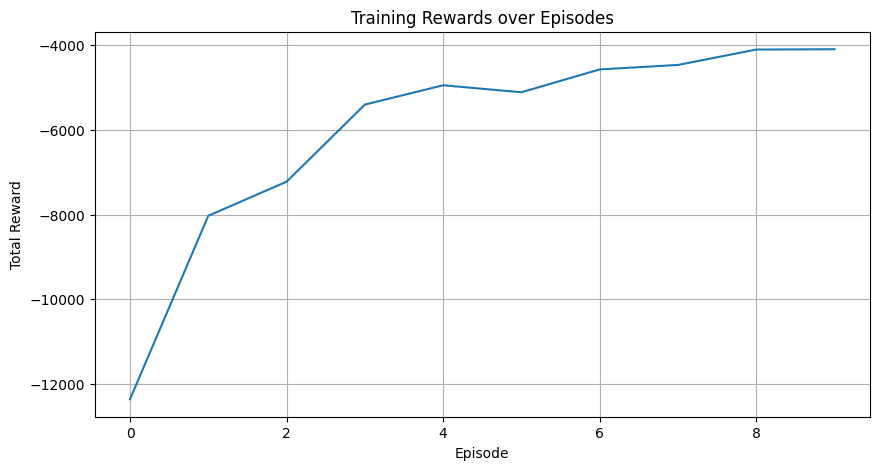

[-12357.0,
 -8027.0,
 -7223.0,
 -5403.0,
 -4947.0,
 -5112.0,
 -4573.0,
 -4467.0,
 -4104.0,
 -4096.0]

In [4]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("SUMO_HOME not found")

import traci

class RampMeteringEnv:
    def __init__(self):
        self.cfg_path = str(Path("D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"))
        self.sumoCmd = ["sumo", "-c", self.cfg_path, "--no-step-log", "--no-warnings"]
        
        self.n_states = 4  # [mainline_density, ramp_density, mainline_speed, ramp_speed]
        self.n_actions = 4  # Different metering rates
        self.q_table = {}  # Dictionary for state-action pairs
        
        # Network elements
        self.mainline = "2to3"
        self.ramp = "intramp"
        self.tl_id = "node6"
        

    def start_simulation(self):
        try:
            traci.start(self.sumoCmd)
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False
    def normalize_state(self, value, max_value):
        return min(value / max_value, 1.0)
    def get_q_value(self, state, action=None):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        if action is None:
            return self.q_table[state]
        return self.q_table[state][action]
    def get_state(self):
        # Get raw values
        mainline_density = traci.edge.getLastStepVehicleNumber(self.mainline)
        ramp_density = traci.edge.getLastStepVehicleNumber(self.ramp)
        mainline_speed = traci.edge.getLastStepMeanSpeed(self.mainline)
        ramp_speed = traci.edge.getLastStepMeanSpeed(self.ramp)
        
        # Normalize values
        norm_mainline_density = self.normalize_state(mainline_density, 10)
        norm_ramp_density = self.normalize_state(ramp_density, 10)
        norm_mainline_speed = self.normalize_state(mainline_speed, 13.89)  # 50 km/h
        norm_ramp_speed = self.normalize_state(ramp_speed, 13.89)
        
        return tuple([norm_mainline_density, norm_ramp_density, 
                     norm_mainline_speed, norm_ramp_speed])

    def take_action(self, action):
        green_times = [5, 10, 15, 20]
        try:
            traci.trafficlight.setPhaseDuration(self.tl_id, green_times[action])
            for _ in range(green_times[action]):
                if traci.simulation.getMinExpectedNumber() <= 0:
                    return self.get_state(), 0, True
                traci.simulationStep()
            
            # Calculate negative rewards
            waiting_time = (traci.edge.getWaitingTime(self.mainline) + 
                        traci.edge.getWaitingTime(self.ramp))
            congestion = (traci.edge.getLastStepVehicleNumber(self.mainline) + 
                        traci.edge.getLastStepVehicleNumber(self.ramp))
            
            # Combined negative reward
            reward = -(waiting_time + congestion * 10)
            
            return self.get_state(), reward, False
        except:
            return self.get_state(), 0, True
def train(episodes=100):
    alpha = 0.001
    gamma = 0.9
    epsilon = 0.1
    epsilon_decay = 0.995
    min_epsilon = 0.01

    env = RampMeteringEnv()
    results = []

    for episode in range(episodes):
        if not env.start_simulation():
            continue
            
        state = env.get_state()
        total_reward = 0
        
        while True:
            action = (np.random.randint(env.n_actions) if np.random.random() < epsilon 
                 else np.argmax(env.get_q_value(state)))
        
            next_state, reward, done = env.take_action(action)
            total_reward += reward
        
            # Update Q-value
            best_next = np.max(env.get_q_value(next_state))
            env.q_table[state][action] += alpha * (reward + gamma * best_next - 
                                             env.q_table[state][action])
            
            state = next_state
            if done:
                break

        traci.close()
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        results.append(total_reward)
        print(f"Episode {episode+1}, Reward: {total_reward:.2f}")

    np.save('q_table.npy', env.q_table)
    # Visualize results after training
    plt.figure(figsize=(10, 5))
    plt.plot(results)
    plt.title('Training Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig('training_rewards.png')
    plt.show()
    return results

train(episodes=10)

Episode 1, Reward: -2274.30
Episode 2, Reward: -1422.90
Episode 3, Reward: -1247.40
Episode 4, Reward: -998.80
Episode 5, Reward: -919.80
Episode 6, Reward: -869.30
Episode 7, Reward: -782.70
Episode 8, Reward: -743.20
Episode 9, Reward: -793.00
Episode 10, Reward: -858.30
Episode 11, Reward: -877.40
Episode 12, Reward: -1047.90
Episode 13, Reward: -900.20
Episode 14, Reward: -892.60
Episode 15, Reward: -930.20
Episode 16, Reward: -869.70
Episode 17, Reward: -890.40
Episode 18, Reward: -995.70
Episode 19, Reward: -888.60
Episode 20, Reward: -972.80
Episode 21, Reward: -1028.50
Episode 22, Reward: -1047.20
Episode 23, Reward: -1001.00
Episode 24, Reward: -983.80
Episode 25, Reward: -920.70
Episode 26, Reward: -975.20
Episode 27, Reward: -920.60
Episode 28, Reward: -892.80
Episode 29, Reward: -993.90
Episode 30, Reward: -1039.10
Episode 31, Reward: -917.20
Episode 32, Reward: -1110.10
Episode 33, Reward: -944.60
Episode 34, Reward: -979.50
Episode 35, Reward: -996.70
Episode 36, Reward: 

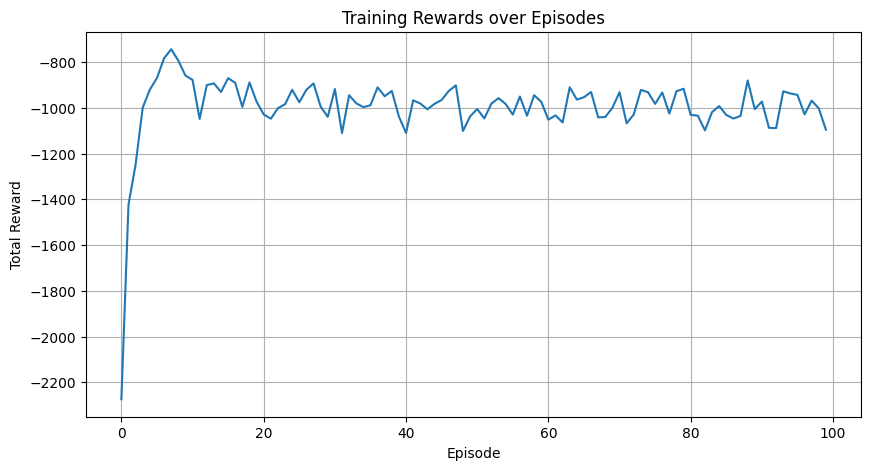

[-2274.3,
 -1422.8999999999996,
 -1247.3999999999996,
 -998.7999999999998,
 -919.8,
 -869.3000000000001,
 -782.7000000000002,
 -743.2000000000003,
 -793.0000000000001,
 -858.3000000000001,
 -877.4,
 -1047.8999999999996,
 -900.1999999999999,
 -892.5999999999998,
 -930.2,
 -869.7000000000002,
 -890.4000000000001,
 -995.6999999999998,
 -888.6,
 -972.7999999999998,
 -1028.4999999999998,
 -1047.1999999999998,
 -1000.9999999999999,
 -983.7999999999998,
 -920.6999999999998,
 -975.1999999999999,
 -920.6,
 -892.8,
 -993.9,
 -1039.0999999999997,
 -917.1999999999999,
 -1110.1,
 -944.6,
 -979.4999999999999,
 -996.6999999999998,
 -988.1999999999998,
 -910.0,
 -948.8,
 -925.8,
 -1038.1,
 -1109.4999999999995,
 -966.8,
 -980.3999999999999,
 -1006.1999999999999,
 -982.1999999999998,
 -965.1999999999998,
 -926.0,
 -901.2000000000003,
 -1100.7999999999997,
 -1037.1,
 -1004.9000000000001,
 -1045.7999999999997,
 -980.8999999999997,
 -957.1999999999999,
 -982.8999999999999,
 -1029.2999999999997,
 -950.10000

In [2]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("SUMO_HOME not found")

import traci

class RampMeteringEnv:
    def __init__(self):
        self.cfg_path = str(Path("D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"))
        self.sumoCmd = ["sumo", "-c", self.cfg_path, "--no-step-log", "--no-warnings"]
        
        self.n_states = 4  # [mainline_density, ramp_density, mainline_speed, ramp_speed]
        self.n_actions = 4  # Different metering rates
        self.q_table = {}  # Dictionary for state-action pairs
        
        self.max_waiting_time = 1000
        self.batch_size = 32
        # Network elements
        self.mainline = "2to3"
        self.ramp = "intramp"
        self.tl_id = "node6"
        

    def start_simulation(self):
        try:
            traci.start(self.sumoCmd)
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False
    def normalize_state(self, value, max_value):
        return min(value / max_value, 1.0)
    def get_q_value(self, state, action=None):
        state = tuple(state)  # Ensure state is a tuple
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        if action is None:
            return self.q_table[state]
        return self.q_table[state][action]
    def get_state(self):
        # Get raw values
        mainline_density = traci.edge.getLastStepVehicleNumber(self.mainline)
        ramp_density = traci.edge.getLastStepVehicleNumber(self.ramp)
        mainline_speed = traci.edge.getLastStepMeanSpeed(self.mainline)
        ramp_speed = traci.edge.getLastStepMeanSpeed(self.ramp)
        
        # Normalize values
        norm_mainline_density = self.normalize_state(mainline_density, 10)
        norm_ramp_density = self.normalize_state(ramp_density, 10)
        norm_mainline_speed = self.normalize_state(mainline_speed, 13.89)  # 50 km/h
        norm_ramp_speed = self.normalize_state(ramp_speed, 13.89)
        
        return tuple([norm_mainline_density, norm_ramp_density, 
                     norm_mainline_speed, norm_ramp_speed])
    def take_action(self, action):
        green_times = [5, 10, 15, 20]
        try:
            traci.trafficlight.setPhaseDuration(self.tl_id, green_times[action])
            for _ in range(green_times[action]):
                if traci.simulation.getMinExpectedNumber() <= 0:
                    return self.get_state(), 0, True
                traci.simulationStep()
            
            # Calculate reward components
            waiting_time = (traci.edge.getWaitingTime(self.mainline) + 
                          traci.edge.getWaitingTime(self.ramp))
            vehicles = (traci.edge.getLastStepVehicleNumber(self.mainline) + 
                       traci.edge.getLastStepVehicleNumber(self.ramp))
            
            # Normalize and combine rewards
            normalized_wait = min(waiting_time / self.max_waiting_time, 1.0)
            normalized_congestion = min(vehicles / 20, 1.0)  # Assume max 20 vehicles
            
            reward = -(normalized_wait * 100 + normalized_congestion * 50)
            
            return self.get_state(), reward, False
        except Exception as e:
            print(f"Error in take_action: {e}")
            return self.get_state(), 0, True
def train(episodes=100):
    alpha = 0.01
    gamma = 0.99
    epsilon = 0.1
    
    env = RampMeteringEnv()
    results = []

    for episode in range(episodes):
        if not env.start_simulation():
            continue
            
        state = env.get_state()
        total_reward = 0
        
        while True:
            action = (np.random.randint(env.n_actions) if np.random.random() < epsilon 
                     else np.argmax(env.get_q_value(state)))
            
            next_state, reward, done = env.take_action(action)
            total_reward += reward
            
            best_next = np.max(env.get_q_value(next_state))
            env.q_table[state][action] += alpha * (reward + gamma * best_next - 
                                                 env.q_table[state][action])
            
            state = next_state
            if done:
                break

        traci.close()
        results.append(total_reward)
        print(f"Episode {episode+1}, Reward: {total_reward:.2f}")

    np.save('q_table.npy', env.q_table)
    # Visualize results after training
    plt.figure(figsize=(10, 5))
    plt.plot(results)
    plt.title('Training Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig('training_rewards.png')
    plt.show()
    return results

train(episodes=100)